# Pre-process VESPA Dataset

**Publication**: George Rosenberger et al. Network-based elucidation of colon cancer drug resistance mechanisms by phosphoproteomic time-series analysis

In [1]:
import pandas as pd
import os
from plotnine import ggplot, aes, geom_histogram, geom_point, geom_violin, labs, theme_classic, theme, ylim
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA

## Load & format data

Data are loaded and split into two dataframes. `map_protein` contains all the information to map the phosphosites to the peptides, proteins and genes. `phospho_data` have the phosphopeptide measurements and the experiment metadata. Time is also processed to convert hours to minutes.

In [2]:
file_path = os.path.join('..', 'data_raw', 'VESPA', 'U54_COAD_phospho.csv')
vespa_df = pd.read_csv(file_path)
display(vespa_df.head())

,gene_id,protein_id,peptide_id,site_id,modified_peptide_sequence,peptide_sequence,phosphosite,run_id,peptide_intensity
0,CCNL2,Q96S94,.(Acetyl)AAAAAAAGAAGS(Phospho)AAPAAAAGAPGSGGAP...,CCNL2:Q96S94:S13,.(Acetyl)AAAAAAAGAAGS(Phospho)AAPAAAAGAPGSGGAP...,AAAAAAAGAAGSAAPAAAAGAPGSGGAPSGSQGVLIGDR,S13,H508_AL_96h,-1.042529
1,CCNL2,Q96S94,.(Acetyl)AAAAAAAGAAGS(Phospho)AAPAAAAGAPGSGGAP...,CCNL2:Q96S94:S13,.(Acetyl)AAAAAAAGAAGS(Phospho)AAPAAAAGAPGSGGAP...,AAAAAAAGAAGSAAPAAAAGAPGSGGAPSGSQGVLIGDR,S13,H508_C_6h,-1.088421
2,CCNL2,Q96S94,.(Acetyl)AAAAAAAGAAGS(Phospho)AAPAAAAGAPGSGGAP...,CCNL2:Q96S94:S13,.(Acetyl)AAAAAAAGAAGS(Phospho)AAPAAAAGAPGSGGAP...,AAAAAAAGAAGSAAPAAAAGAPGSGGAPSGSQGVLIGDR,S13,H508_C_5min,-0.879078
3,CCNL2,Q96S94,.(Acetyl)AAAAAAAGAAGS(Phospho)AAPAAAAGAPGSGGAP...,CCNL2:Q96S94:S13,.(Acetyl)AAAAAAAGAAGS(Phospho)AAPAAAAGAPGSGGAP...,AAAAAAAGAAGSAAPAAAAGAPGSGGAPSGSQGVLIGDR,S13,H508_AL_24h,-2.313677
4,CCNL2,Q96S94,.(Acetyl)AAAAAAAGAAGS(Phospho)AAPAAAAGAPGSGGAP...,CCNL2:Q96S94:S13,.(Acetyl)AAAAAAAGAAGS(Phospho)AAPAAAAGAPGSGGAP...,AAAAAAAGAAGSAAPAAAAGAPGSGGAPSGSQGVLIGDR,S13,HT115_OS_48h,-0.700137


In [3]:
# Split the DataFrame into map_protein and phospho_data
map_protein = vespa_df[['site_id', 'gene_id', 'protein_id', 'peptide_id', 'modified_peptide_sequence', 'peptide_sequence', 'phosphosite']]
phospho_data = vespa_df[['site_id', 'run_id', 'peptide_intensity']].copy()

phospho_data[['Cell_line', 'Drug', 'Time']] = phospho_data['run_id'].str.split('_', expand=True)  # Create experiment metadata variables
phospho_data = phospho_data.drop(columns=['run_id'])

# Convert hours to minutes in Time where required
def convert_time(time_str):
    if 'h' in time_str:
        return int(time_str.replace('h', '')) * 60
    elif 'min' in time_str:
        return int(time_str.replace('min', ''))
    else:
        return int(time_str)

phospho_data['Time'] = phospho_data['Time'].apply(convert_time)

bl_data = phospho_data[phospho_data['Drug'].isin(['BL1', 'BL2', 'BL3'])]  # Separate base line data to explore
phospho_data = phospho_data[~phospho_data['Drug'].isin(['BL1', 'BL2', 'BL3'])]  # Filter out these BL classes as currently unknown

display(map_protein.head())
display(phospho_data.head())
display(bl_data.head())

,site_id,gene_id,protein_id,peptide_id,modified_peptide_sequence,peptide_sequence,phosphosite
0,CCNL2:Q96S94:S13,CCNL2,Q96S94,.(Acetyl)AAAAAAAGAAGS(Phospho)AAPAAAAGAPGSGGAP...,.(Acetyl)AAAAAAAGAAGS(Phospho)AAPAAAAGAPGSGGAP...,AAAAAAAGAAGSAAPAAAAGAPGSGGAPSGSQGVLIGDR,S13
1,CCNL2:Q96S94:S13,CCNL2,Q96S94,.(Acetyl)AAAAAAAGAAGS(Phospho)AAPAAAAGAPGSGGAP...,.(Acetyl)AAAAAAAGAAGS(Phospho)AAPAAAAGAPGSGGAP...,AAAAAAAGAAGSAAPAAAAGAPGSGGAPSGSQGVLIGDR,S13
2,CCNL2:Q96S94:S13,CCNL2,Q96S94,.(Acetyl)AAAAAAAGAAGS(Phospho)AAPAAAAGAPGSGGAP...,.(Acetyl)AAAAAAAGAAGS(Phospho)AAPAAAAGAPGSGGAP...,AAAAAAAGAAGSAAPAAAAGAPGSGGAPSGSQGVLIGDR,S13
3,CCNL2:Q96S94:S13,CCNL2,Q96S94,.(Acetyl)AAAAAAAGAAGS(Phospho)AAPAAAAGAPGSGGAP...,.(Acetyl)AAAAAAAGAAGS(Phospho)AAPAAAAGAPGSGGAP...,AAAAAAAGAAGSAAPAAAAGAPGSGGAPSGSQGVLIGDR,S13
4,CCNL2:Q96S94:S13,CCNL2,Q96S94,.(Acetyl)AAAAAAAGAAGS(Phospho)AAPAAAAGAPGSGGAP...,.(Acetyl)AAAAAAAGAAGS(Phospho)AAPAAAAGAPGSGGAP...,AAAAAAAGAAGSAAPAAAAGAPGSGGAPSGSQGVLIGDR,S13


,site_id,peptide_intensity,Cell_line,Drug,Time
0,CCNL2:Q96S94:S13,-1.042529,H508,AL,5760
1,CCNL2:Q96S94:S13,-1.088421,H508,C,360
2,CCNL2:Q96S94:S13,-0.879078,H508,C,5
3,CCNL2:Q96S94:S13,-2.313677,H508,AL,1440
4,CCNL2:Q96S94:S13,-0.700137,HT115,OS,2880


,site_id,peptide_intensity,Cell_line,Drug,Time
20,EIF3J:O75822:S11,2.724024,SNU,BL1,0
21,EIF3J:O75822:S13,2.724024,SNU,BL1,0
42,EIF3J:O75822:S11,3.457526,HT115,BL1,0
43,EIF3J:O75822:S13,3.457526,HT115,BL1,0
70,EIF3J:O75822:S11,3.400686,LS,BL1,0


In [4]:
# Identify and print unique Time, Drug, and Cell_line values and their counts
unique_times = phospho_data['Time'].unique()
unique_drugs = phospho_data['Drug'].unique()
unique_cell_lines = phospho_data['Cell_line'].unique()
unique_times_bl = bl_data['Time'].unique()
unique_drugs_bl = bl_data['Drug'].unique()
unique_cell_lines_bl = bl_data['Cell_line'].unique()

print(f"Unique Time values: {unique_times}")
print(f"Number of unique Time values: {len(unique_times)}")

print(f"Unique Drug values: {unique_drugs}")
print(f"Number of unique Drug values: {len(unique_drugs)}")

print(f"Unique Cell_line values: {unique_cell_lines}")
print(f"Number of unique Cell_line values: {len(unique_cell_lines)}")

print("--- Base line samples ---")
print(f"Unique Time values: {unique_times_bl}")
print(f"Number of unique Time values: {len(unique_times_bl)}")

print(f"Unique Drug values: {unique_drugs_bl}")
print(f"Number of unique Drug values: {len(unique_drugs_bl)}")

print(f"Unique Cell_line values: {unique_cell_lines_bl}")
print(f"Number of unique Cell_line values: {len(unique_cell_lines_bl)}")

Unique Time values: [5760  360    5 1440 2880   60   15]
Number of unique Time values: 7
Unique Drug values: ['AL' 'C' 'OS' 'LI' 'WI' 'RA' 'IM' 'TR']
Number of unique Drug values: 8
Unique Cell_line values: ['H508' 'HT115' 'SNU' 'M8' 'HCT' 'LS']
Number of unique Cell_line values: 6
--- Base line samples ---
Unique Time values: [0]
Number of unique Time values: 1
Unique Drug values: ['BL1' 'BL2' 'BL3']
Number of unique Drug values: 3
Unique Cell_line values: ['SNU' 'HT115' 'LS' 'M8' 'H508' 'HCT']
Number of unique Cell_line values: 6


Widen the data to have phosphosites as columns and samples as rows.

In [5]:
phospho_data_wide = phospho_data.pivot_table(index=['Cell_line', 'Drug', 'Time'], columns='site_id', values='peptide_intensity')
phospho_data_wide = phospho_data_wide.reset_index()

print(phospho_data_wide.shape)
display(phospho_data_wide.head())

(336, 14379)


site_id,Cell_line,Drug,Time,AAAS:Q9NRG9:S495,AAAS:Q9NRG9:S541,AAK1:Q2M2I8:S624,AAK1:Q2M2I8:S637,AAK1:Q2M2I8:S676,AAK1:Q2M2I8:S678,AAK1:Q2M2I8:T389,...,ZYX:Q15942:S308,ZYX:Q15942:S344,ZYX:Q15942:T159,ZYX:Q15942:T270,ZYX:Q15942:T274,ZZEF1:O43149:S1518,ZZEF1:O43149:S2443,ZZEF1:O43149:S2444,ZZZ3:Q8IYH5:S113,ZZZ3:Q8IYH5:S82
0,H508,AL,5,2.663989,NaN,NaN,1.623195,NaN,NaN,NaN,...,NaN,1.015650,NaN,-2.631489,-3.495737,NaN,NaN,NaN,NaN,-4.185940
1,H508,AL,15,2.088454,NaN,NaN,1.386295,NaN,NaN,-2.822999,...,NaN,0.449308,NaN,-2.497215,-3.598141,NaN,NaN,NaN,-2.612435,-3.839546
2,H508,AL,60,2.339513,NaN,2.349995,0.085881,NaN,NaN,NaN,...,NaN,1.291104,NaN,-1.971568,-2.596486,NaN,NaN,NaN,-2.034145,-4.039542
3,H508,AL,360,2.508059,NaN,NaN,1.637429,NaN,-0.580961,-2.396530,...,NaN,0.948047,NaN,-2.044746,-2.952332,NaN,NaN,NaN,-2.360951,-4.433173
4,H508,AL,1440,2.285519,NaN,2.565329,0.975331,NaN,NaN,-3.220878,...,NaN,0.744631,NaN,-2.881922,-4.806480,NaN,NaN,NaN,NaN,NaN


## Exploratory data analysis

First of all, we should check the missing value percentages across samples and across phosphosites.

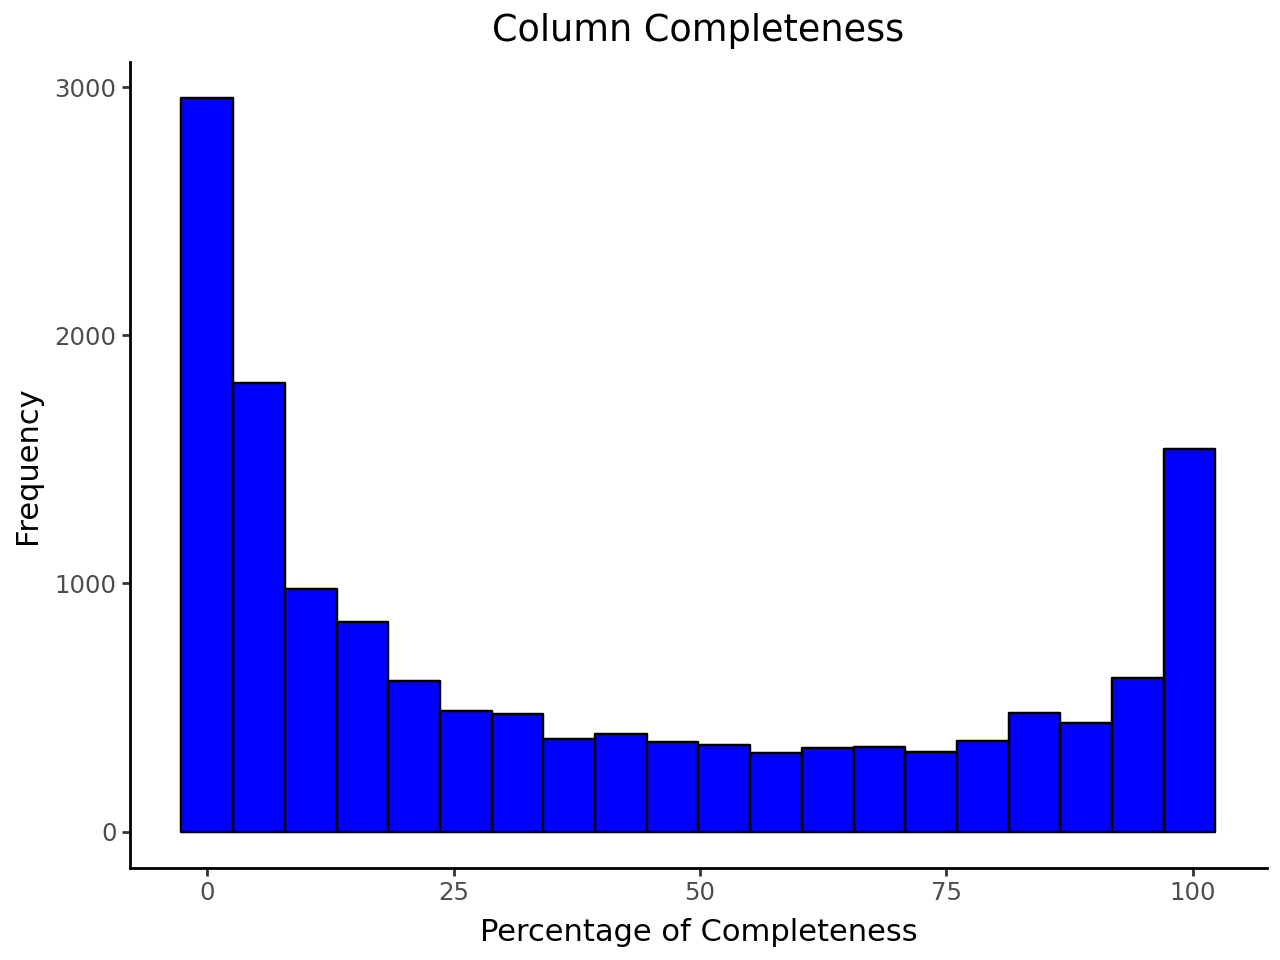

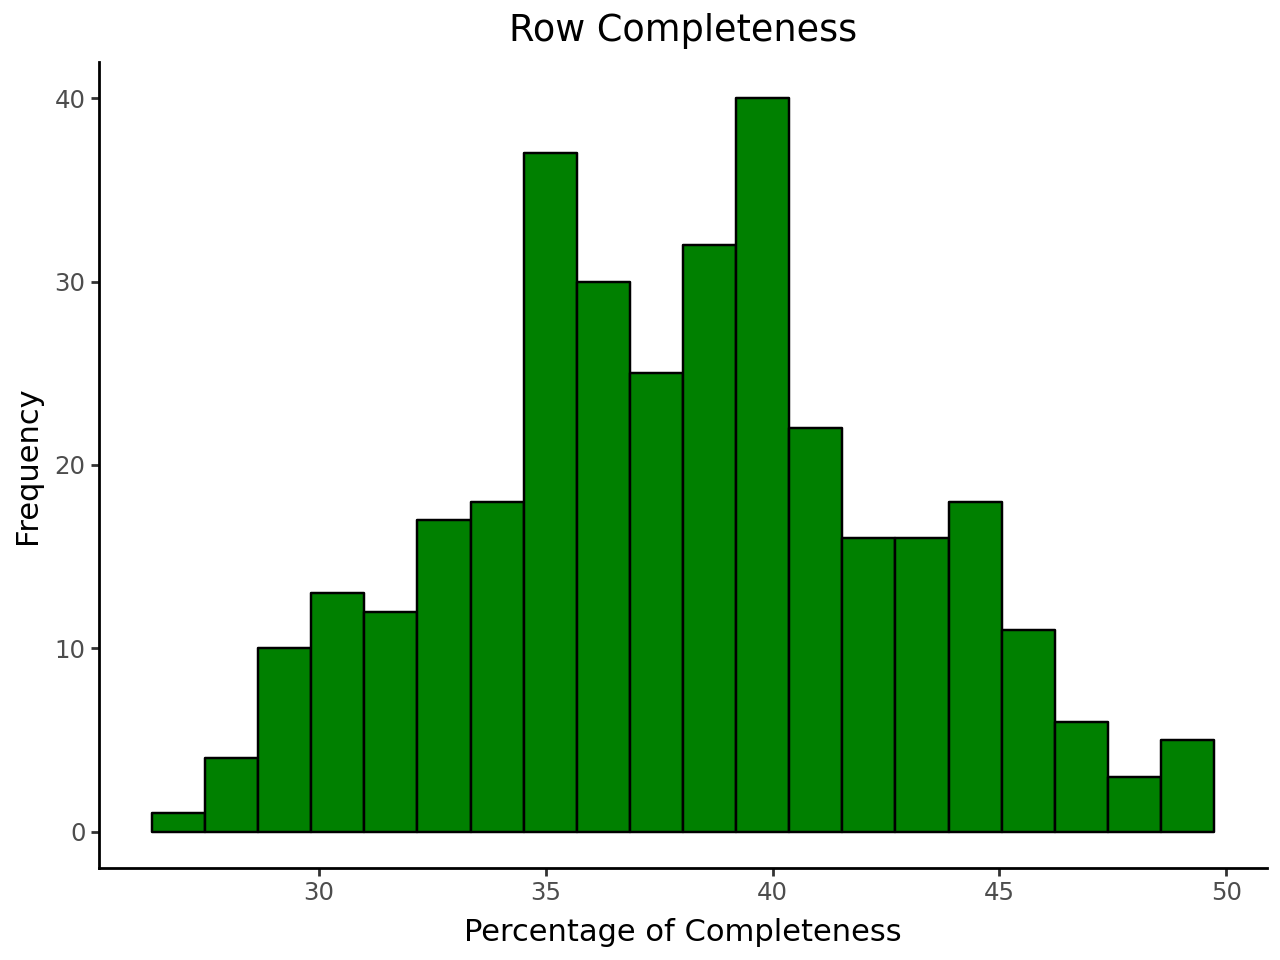

In [6]:
# Calculate the percentage of completeness across rows and columns (excluding Cell_line, Drug, and Time)
column_completeness = phospho_data_wide.drop(columns=['Cell_line', 'Drug', 'Time']).notna().mean() * 100
row_completeness = phospho_data_wide.drop(columns=['Cell_line', 'Drug', 'Time']).notna().mean(axis=1) * 100

column_completeness_df = pd.DataFrame({'Completeness': column_completeness})
row_completeness_df = pd.DataFrame({'Completeness': row_completeness})

# Histogram for column completeness
p1 = (ggplot(column_completeness_df, aes(x='Completeness')) +
      geom_histogram(bins=20, fill='blue', color='black') +
      labs(title='Column Completeness',
           x='Percentage of Completeness',
           y='Frequency') +
      theme_classic())

# Histogram for row completeness
p2 = (ggplot(row_completeness_df, aes(x='Completeness')) +
      geom_histogram(bins=20, fill='green', color='black') +
      labs(title='Row Completeness',
           x='Percentage of Completeness',
           y='Frequency') +
      theme_classic())

p1.show()
p2.show()

Filter out phosphosites with less than 50% completeness, impute the data using KNN (k = 5) and run PCA to assess batch effects and outliers.

In [7]:
# Exclude columns with less than 50% completeness
completeness_threshold = 50
column_completeness = phospho_data_wide.drop(columns=['Cell_line', 'Drug', 'Time']).notna().mean() * 100
columns_to_keep = column_completeness[column_completeness >= completeness_threshold].index
phospho_data_filtered = phospho_data_wide[['Cell_line', 'Drug', 'Time'] + list(columns_to_keep)]

# KNN impute with 5 neighbors
imputer = KNNImputer(n_neighbors=5)
phospho_data_imputed = phospho_data_filtered.copy()
phospho_data_imputed.iloc[:, 3:] = imputer.fit_transform(phospho_data_filtered.iloc[:, 3:])

# Run PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(phospho_data_imputed.iloc[:, 3:])
pca_df = pd.DataFrame(pca_results, columns=['PC1', 'PC2'])
pca_df['Time'] = phospho_data_imputed['Time'].astype(str)
pca_df['Drug'] = phospho_data_imputed['Drug']
pca_df['Cell_line'] = phospho_data_imputed['Cell_line']

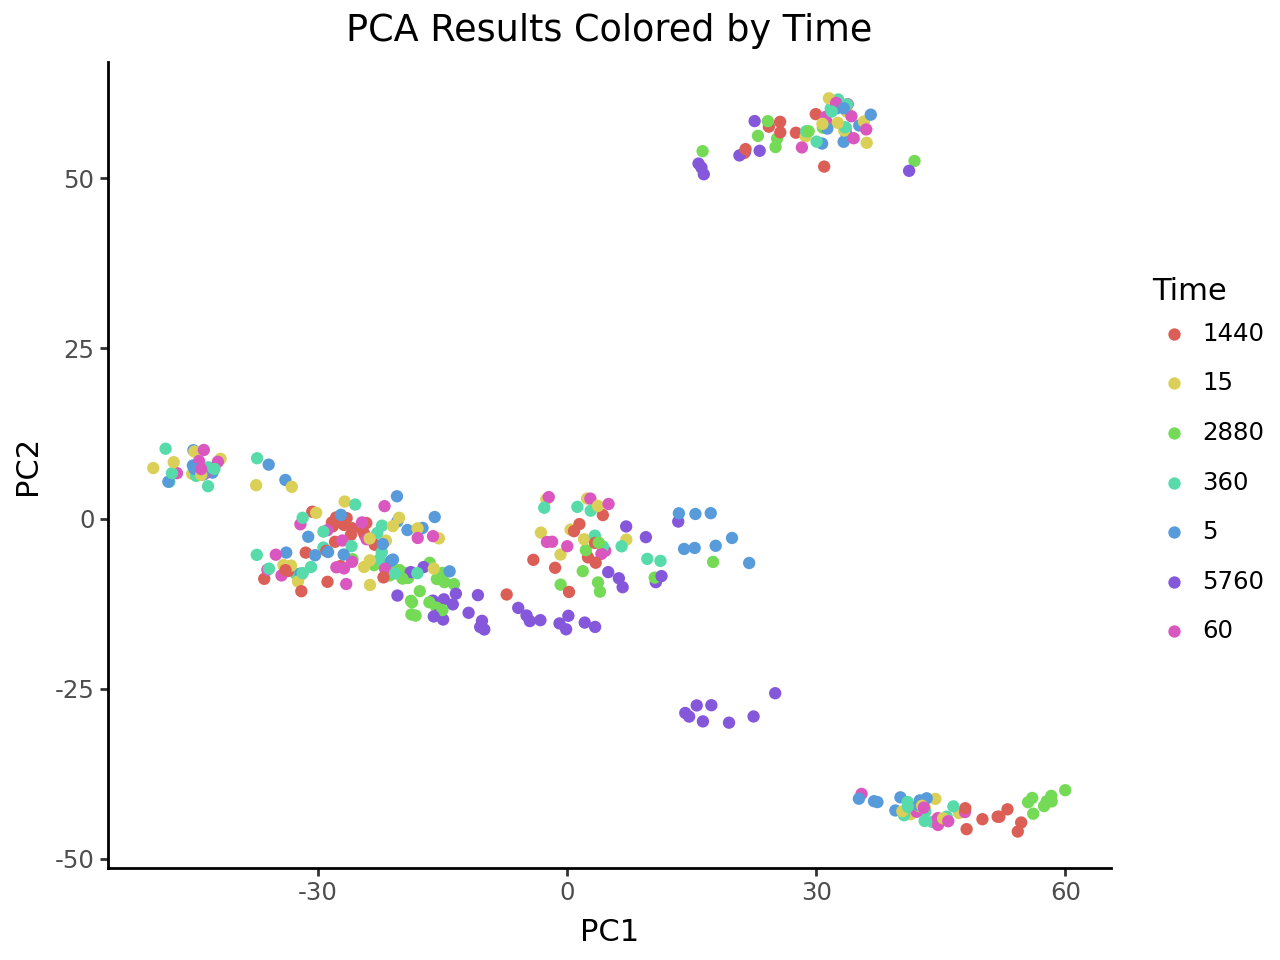

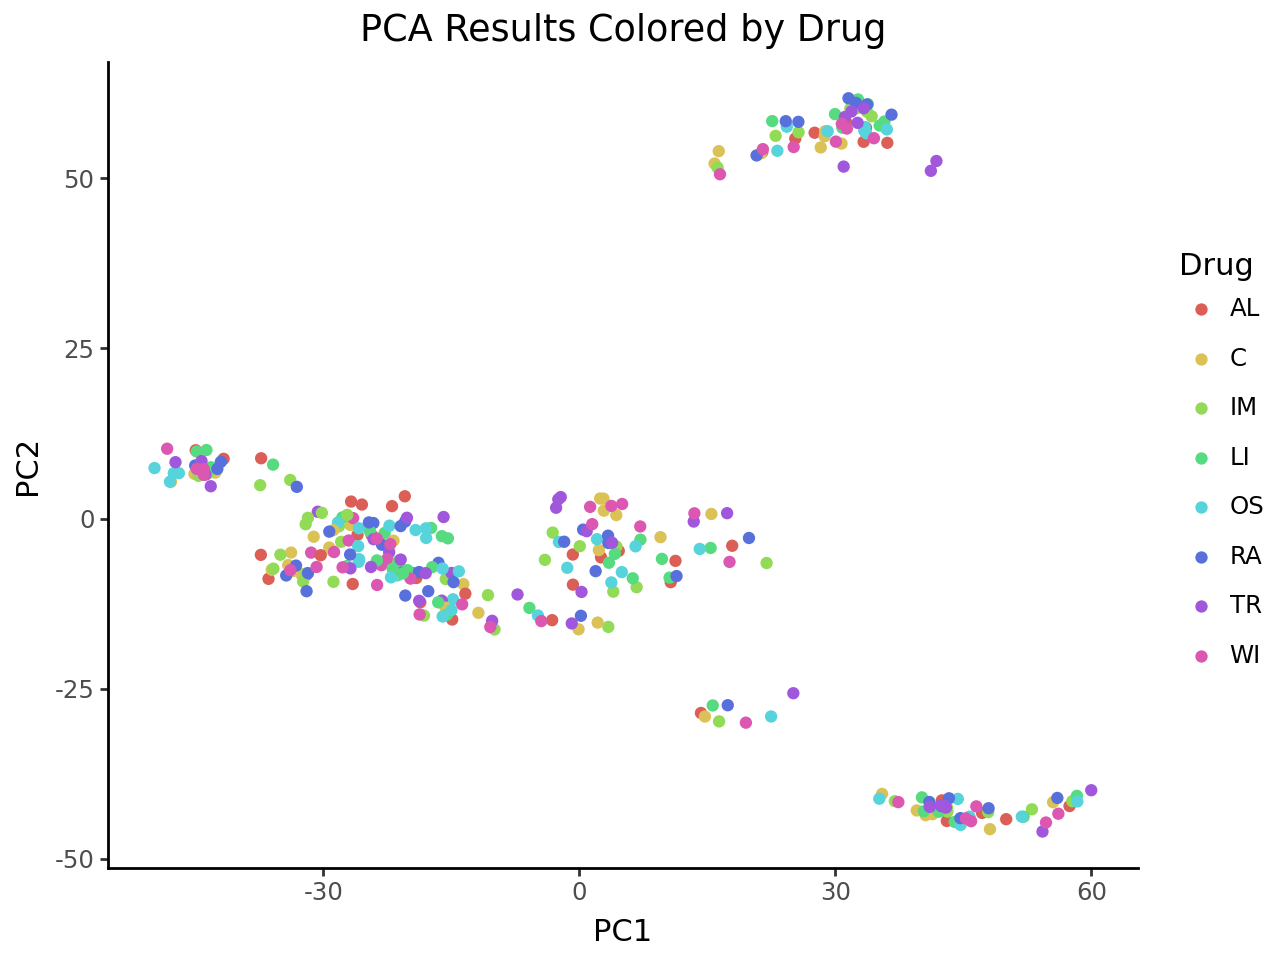

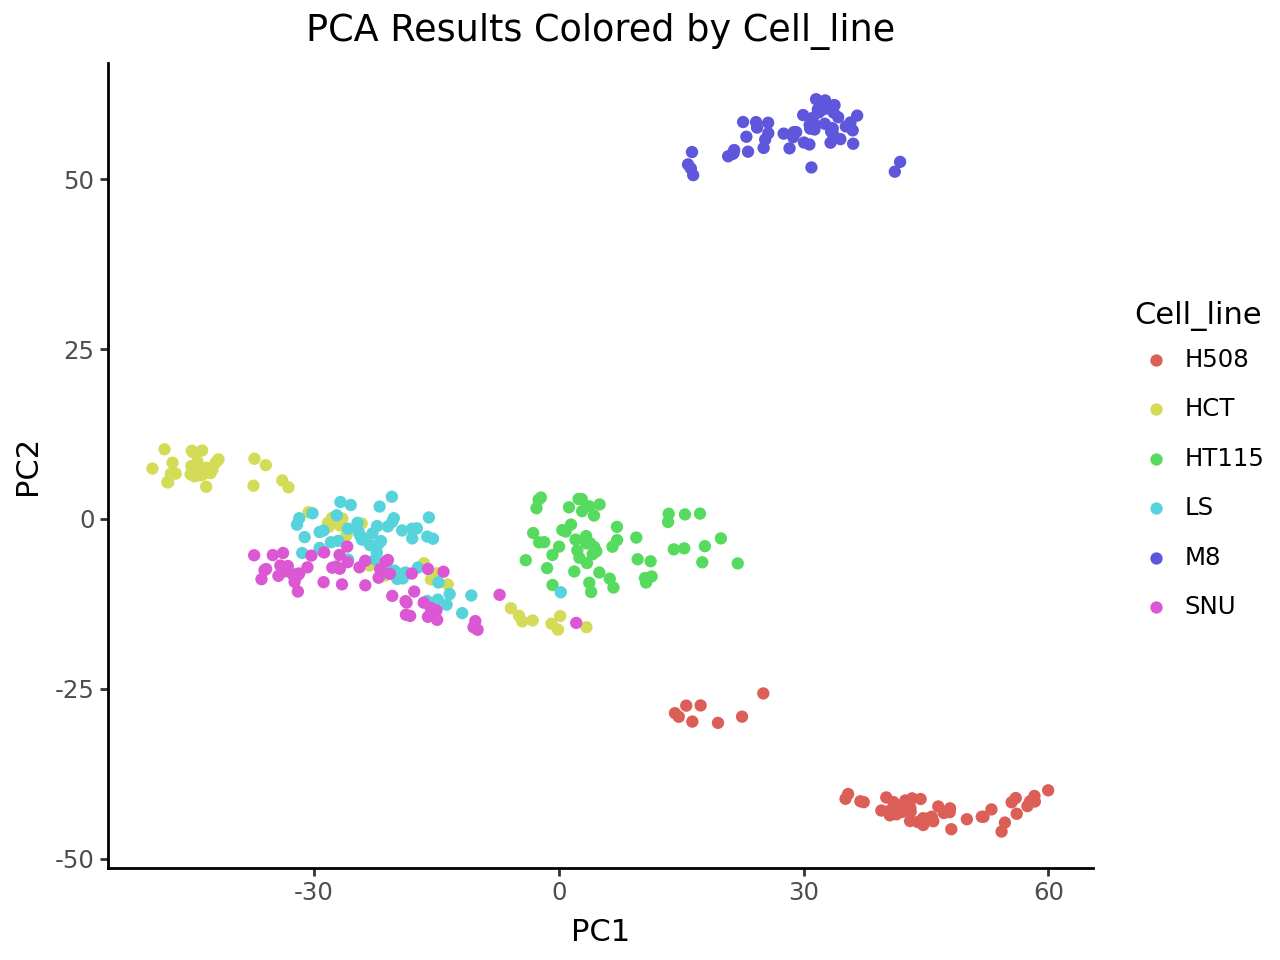

In [8]:
# Color by Time
plot_time = (ggplot(pca_df, aes(x='PC1', y='PC2', color='Time')) +
             geom_point() +
             labs(title='PCA Results Colored by Time', x='PC1', y='PC2') +
             theme_classic())
plot_time.show()

# Color by Drug
plot_drug = (ggplot(pca_df, aes(x='PC1', y='PC2', color='Drug')) +
             geom_point() +
             labs(title='PCA Results Colored by Drug', x='PC1', y='PC2') +
             theme_classic())
plot_drug.show()

# Color by Cell_line
plot_cell_line = (ggplot(pca_df, aes(x='PC1', y='PC2', color='Cell_line')) +
                  geom_point() +
                  labs(title='PCA Results Colored by Cell_line', x='PC1', y='PC2') +
                  theme_classic())
plot_cell_line.show()

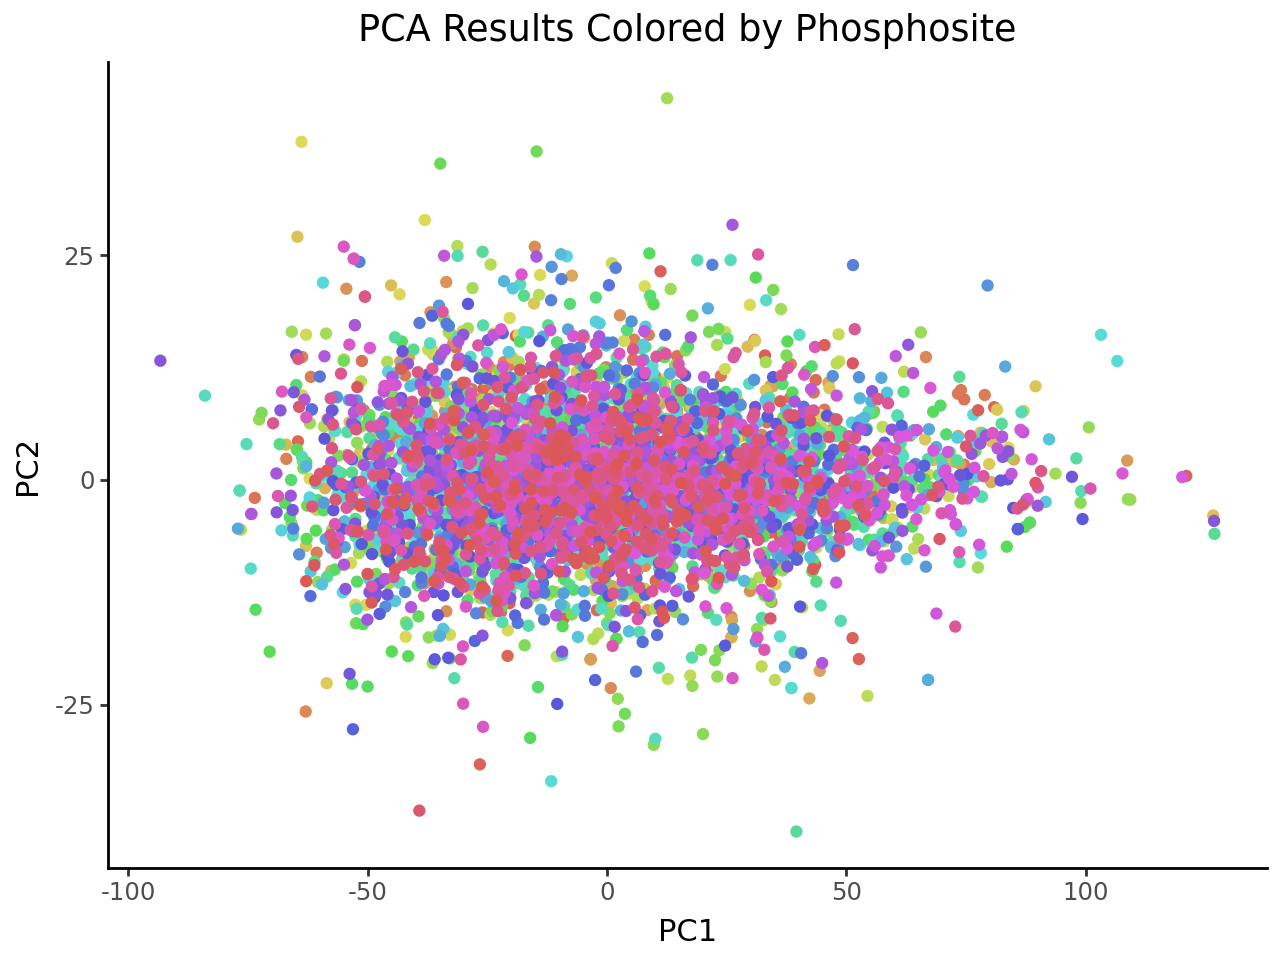

In [9]:
phospho_data_transformed = phospho_data_imputed.drop(columns=['Cell_line', 'Drug', 'Time'])

# Run PCA on the transformed dataframe
pca_transformed = PCA(n_components=2)
pca_results_transformed = pca_transformed.fit_transform(phospho_data_transformed.T)
pca_df_transformed = pd.DataFrame(pca_results_transformed, columns=['PC1', 'PC2'])
pca_df_transformed['Phosphosite'] = phospho_data_transformed.columns

# Plot PCA results colored by Phosphosite
plot_phosphosite = (ggplot(pca_df_transformed, aes(x='PC1', y='PC2', color='Phosphosite')) +
                    geom_point() +
                    labs(title='PCA Results Colored by Phosphosite', x='PC1', y='PC2') +
                    theme_classic() + 
                    theme(legend_position='none'))
plot_phosphosite.show()

c:\Users\kanto\anaconda3\envs\deeplearning\Lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_ydensity : Removed 6068 rows containing non-finite values.


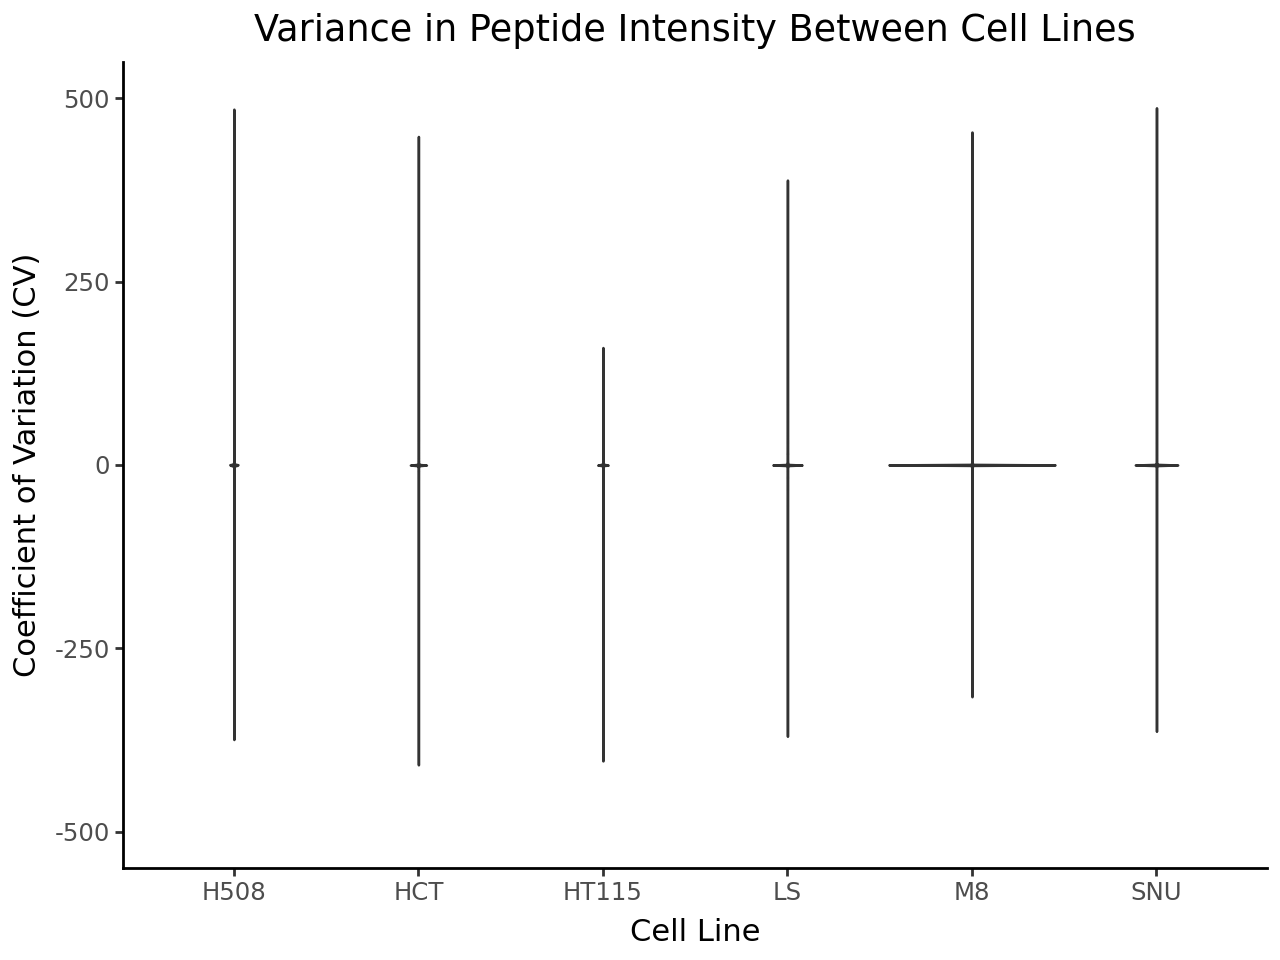

In [10]:
# Calculate the variance (normalized) for each phosphosite across the 3 replicates for each cell line
mean_variance_data = bl_data.groupby(['Cell_line', 'site_id'])['peptide_intensity'].agg(['mean', 'var']).reset_index()
mean_variance_data['CV'] = mean_variance_data['var'] / mean_variance_data['mean']

box_plot_variance = (ggplot(mean_variance_data, aes(x='Cell_line', y='CV', fill='Cell_line')) +
                     geom_violin() +
                     labs(title='Variance in Peptide Intensity Between Cell Lines',
                          x='Cell Line',
                          y='Coefficient of Variation (CV)') +
                     theme_classic() +
                     theme(legend_position='none') +
                     ylim(-500, 500))
box_plot_variance.show()